In [3]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as nc
from gi.repository import NumCosmoMath as ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
import pyccl as ccl
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count

ncm.cfg_init()

cosmo = nc.HICosmo.new_from_name (nc.HICosmo, "NcHICosmoDEXcdm")
primo = nc.HIPrimPowerLaw.new ()

cosmo.add_submodel(primo)

cosmo.props.Omegab  = 0.048254
cosmo.props.Omegac  = 0.30711 - 0.048254
cosmo.props.H0 = 67.7
cosmo.props.Omegax = 1 - 0.30711
primo.props.n_SA = 0.96

dist = nc.Distance.new (2.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `Cosmological models`

In [4]:
#Numcosmo cosmology
cosmo = nc.HICosmo.new_from_name (nc.HICosmo, "NcHICosmoDEXcdm")
primo = nc.HIPrimPowerLaw.new ()

cosmo.add_submodel(primo)

cosmo.props.Omegab  = 0.048254
cosmo.props.Omegac  = 0.30711 - 0.048254
cosmo.props.H0 = 67.7
cosmo.props.Omegax = 1 - 0.30711
primo.props.n_SA = 0.96

dist = nc.Distance.new (2.0)

cosmo = nc.HICosmo.new_from_name (nc.HICosmo, "NcHICosmoDEXcdm")
primo = nc.HIPrimPowerLaw.new ()

cosmo.add_submodel(primo)

cosmo.props.Omegab  = 0.048254
cosmo.props.Omegac  = 0.30711 - 0.048254
cosmo.props.H0 = 67.7
cosmo.props.Omegax = 1 - 0.30711
primo.props.n_SA = 0.96

dist = nc.Distance.new (2.0)

#CCL cosmology
cosmo_ccl = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8822714165197718, n_s=0.96, Omega_k = 0)

initialize the `ClusterAbundance` object

In [15]:
#Numcosmo Cluster Abundance


#First we need to define the mulltiplicity function here we will use the tinker
mulf = nc.MultiplicityFuncTinker.new()
mulf.set_mdef(nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)
#Second we need to construct a filtered power spectrum 

#Here we are using the EH transfer function and ml power spectrum with a tophat filter
tf = nc.TransferFunc.new_from_name('NcTransferFuncEH')

psml = nc.PowspecMLTransfer.new(tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = ncm.PowspecFilter.new(psml,ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)


hmf =  nc.HaloMassFunction.new(dist,psf,mulf)
hmf.set_area((0.25)*4*np.pi)


#Here we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = nc.ClusterMass.new_from_name("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (math.log(10)*np.log10(1e14),math.log(10)*np.log10(1e16)))
cluster_z = nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0.25,1.5))

ca = nc.ClusterAbundance.new(hmf,None)
mset = ncm.MSet.new_array([cosmo,cluster_m,cluster_z])
mset.pretty_log()
print('sigma8 = '+str(cosmo.sigma8(psf)))

0
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.7                [FIXED]
#   -     Omegac[01]:  0.258856            [FIXED]
#   -     Omegax[02]:  0.69289             [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.048254            [FIXED]
#   -          w[07]: -1                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00]:  3.179               [FIXED]
#   - T_SA_ratio[01]:  0.2             

In [6]:
#CCL Cluster Abundance
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo_ccl, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

In [7]:
#Bins definition
z_nodes = np.linspace(0.25, 1.25, 16)
log10M_nodes = np.linspace(14, 14.8, 11)
lnM_nodes = log10M_nodes * math.log(10)


#Numcosmo cluster counts in the bins

Numcosmo_Abundance = []
ca.prepare (cosmo, cluster_z, cluster_m)
for zl, zu in zip (z_nodes, z_nodes[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip (lnM_nodes, lnM_nodes[1:]):
        Pbin = ca.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None)
        print ("(% 20.13g % 20.13g) (% 20.13g % 20.13g) % 20.13g" % (lnMl / math.log(10), lnMu / math.log(10), zl, zu, Pbin))
        nc_bin_mass.append(Pbin)
    Numcosmo_Abundance.append(nc_bin_mass)


#Numcosmo_Abundance[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

(                  14                14.08) (                0.25      0.3166666666667)       2698.695521198
(               14.08                14.16) (                0.25      0.3166666666667)       2105.102061632
(               14.16                14.24) (                0.25      0.3166666666667)       1623.993612936
(               14.24                14.32) (                0.25      0.3166666666667)       1237.250896673
(               14.32                 14.4) (                0.25      0.3166666666667)       929.3471359252
(                14.4                14.48) (                0.25      0.3166666666667)       686.9586913367
(               14.48                14.56) (                0.25      0.3166666666667)       498.6411457099
(               14.56                14.64) (                0.25      0.3166666666667)       354.5620833538
(               14.64                14.72) (                0.25      0.3166666666667)       246.2831219175
(               14.

In [8]:
#CCL cluster count in the bins
CCL_Abundance_exact = clc.Cluster_Abundance_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, method = 'exact')
i = 0
for zl, zu in zip (z_nodes, z_nodes[1:]):
    j = 0
    for lnMl, lnMu in zip (lnM_nodes, lnM_nodes[1:]):
        print("(% 20.13g % 20.13g) (% 20.13g % 20.13g) % 20.13g" % (lnMl / math.log(10), lnMu / math.log(10), zl, zu, CCL_Abundance_exact[i][j]))
        j +=1
    i +=1

#CCL_Abundance_exact[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

(                  14                14.08) (                0.25      0.3166666666667)       2736.998707946
(               14.08                14.16) (                0.25      0.3166666666667)        2134.28048386
(               14.16                14.24) (                0.25      0.3166666666667)       1645.593749038
(               14.24                14.32) (                0.25      0.3166666666667)       1252.698092099
(               14.32                 14.4) (                0.25      0.3166666666667)       939.9271076118
(                14.4                14.48) (                0.25      0.3166666666667)       693.8086057655
(               14.48                14.56) (                0.25      0.3166666666667)       502.7370245217
(               14.56                14.64) (                0.25      0.3166666666667)       356.7178464758
(               14.64                14.72) (                0.25      0.3166666666667)       247.1547051446
(               14.

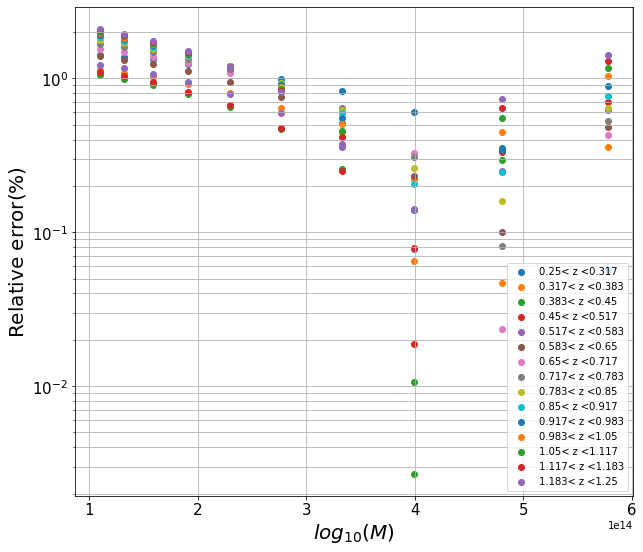

In [9]:
diff = []
for i in range(len(CCL_Abundance_exact)):
        diff.append(abs(100*(Numcosmo_Abundance[i]-CCL_Abundance_exact[i])/Numcosmo_Abundance[i]))


plt.figure(figsize = (10,9))
plt.yscale('log')
z_ = [np.mean([z_nodes[i],z_nodes[i+1]]) for i in np.arange(len(z_nodes)-1)]
mass = [np.mean([10**log10M_nodes[i],10**log10M_nodes[i+1]]) for i in np.arange(len(log10M_nodes)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
legend = []
for i in range(len(z_)):
        plt.scatter(mass, diff[:][i])
        legend.append(str(round(z_nodes[i],3))+'< z <'+str(round(z_nodes[i+1],3)))
plt.legend(legend,loc =4, fontsize = 10)
plt.grid(True, which="both" )
plt.ylabel(r'Relative error$(\%)$', fontsize = 20)
plt.xlabel(r'$log_{10}(M)$', fontsize = 20)
plt.show()



#diff[i][j] is the percentual difference between Numcosmo and CCL cluster abundance in i-th z_bin and j-th mass_bin

# Un-binned approach

Compute $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

In [10]:
#Generates cluster count catalog data
ncdata = nc.DataClusterNCount.new(ca)
rng = ncm.RNG.pool_get("example_ca_sampling");
ncdata.init_from_sampling(mset,(0.25)*4*np.pi,rng)
ncdata.catalog_save("ca_nodist_binned_numcosmo.fits", True)

ncdata_fits = fits.open('ca_nodist_binned_numcosmo.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort('Z_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.25000780738811257,32.36867631816196,0.25000780738811257,32.36867631816196
0.2500145720037777,32.802860530972566,0.2500145720037777,32.802860530972566
0.2500183472543975,34.088629048246275,0.2500183472543975,34.088629048246275
0.2500186113676877,33.32674511870197,0.2500186113676877,33.32674511870197
0.2500239695999694,32.324569751099304,0.2500239695999694,32.324569751099304
0.25005498001517235,32.41294281062964,0.25005498001517235,32.41294281062964
0.2500587538355386,33.51638531975996,0.2500587538355386,33.51638531975996
0.2500606881069083,32.62194094055767,0.2500606881069083,32.62194094055767
0.2500690707333092,33.923897317858234,0.2500690707333092,33.923897317858234


In [11]:
#Using Numcosmo
d2n = []
for i in ncdata_Table:
    d2n.append(ca.intp_d2n(cosmo,cluster_z,cluster_m,i[1],i[0]))


d2n = np.array(d2n)
d2n


array([171232.45889354,  93871.41377679,   9295.89026942, ...,
       170493.97828714, 103895.19305683, 150710.30396206])

In [12]:
#Using CCL
log10M = np.array(ncdata_Table[1][:]*np.log10(np.exp(1)))
multiplicity_exact = clc.multiplicity_function_individual_MZ(z = np.array(ncdata_Table[0][:]), logm =log10M, method = 'exact')
print(multiplicity_exact)

[127556.60891993  69847.29645408   6819.10696994 ... 127744.21498447
  77671.85390045 112863.42522911]


Text(0, 0.5, 'Relative error $(\\%)$')

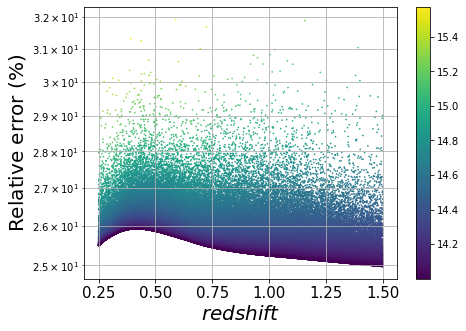

In [13]:
diff = abs((multiplicity_exact-d2n)/d2n)*100

plt.figure(figsize = (7,5))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(ncdata_Table[0][:], diff, s = 0.4, c = log10M)
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 20)
plt.ylabel(r'Relative error $(\%)$', fontsize = 20)
